In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from tqdm import tqdm

# model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import lightgbm as lgb


SEED=42

In [3]:
path = 'drive/My Drive/bigcontest2019/data/'
print(os.listdir(path + 'train'),'\n', 
      os.listdir(path + 'test'),'\n', 
#       os.listdir(path + '../metrics'),'\n', 
      os.listdir(path + '../scripts'))

['train_payment.csv', 'train_trade.csv', 'train_pledge.csv', 'train_combat.csv', 'train_label.csv', 'train_activity.csv'] 
 ['test1_activity.csv', 'test1_combat.csv', 'test2_activity.csv', 'test1_pledge.csv', 'test2_combat.csv', 'test2_trade.csv', 'test1_trade.csv', 'test1_payment.csv', 'test2_payment.csv', 'test2_pledge.csv'] 
 ["hh's work", 'model', 'explortary data', 'data merge', 'metrics']


In [0]:
train_label = pd.read_csv(path + 'train/train_label.csv')
train_activity = pd.read_csv(path + 'train/train_activity.csv')
#train_combat = pd.read_csv(path + 'train/train_combat.csv')
train_payment = pd.read_csv(path + 'train/train_payment.csv')
#train_pledge = pd.read_csv(path + 'train/train_pledge.csv')
#train_trade = pd.read_csv(path + 'train/train_trade.csv')

test1_activity = pd.read_csv(path + 'test/test1_activity.csv')
#test1_combat = pd.read_csv(path + 'test/test1_combat.csv')
test1_payment = pd.read_csv(path + 'test/test1_payment.csv')
#test1_pledge = pd.read_csv(path + 'test/test1_pledge.csv')
#test1_trade = pd.read_csv(path + 'test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'test/test2_activity.csv')
#test2_combat = pd.read_csv(path + 'test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'test/test2_payment.csv')
#test2_pledge = pd.read_csv(path + 'test/test2_pledge.csv')
#test2_trade = pd.read_csv(path + 'test/test2_trade.csv')

In [0]:
def add_week(activity):
  activity['week'] = ((activity['day']-1)//7)+1
  
  return activity

In [0]:
train_activity = add_week(train_activity)
test1_activity = add_week(test1_activity)
test2_activity = add_week(test2_activity)

In [0]:
activity_agg = {'day':'nunique', 
               #'char_id':'nunique',
               #'server':'nunique', 
               'playtime':'sum', 
               'npc_kill':'sum', 
               'solo_exp':'sum',
               'party_exp':'sum', 
               'quest_exp':'sum',
               'rich_monster':'sum', 
               'death':'sum', 
               'revive':'sum',
               'exp_recovery':'sum',
               'fishing':'sum',
               'private_shop':'sum',
               'game_money_change':'sum',
               'enchant_count':'sum'}

In [0]:
train_activity_by_week = train_activity.groupby(['acc_id', 'week']).agg(activity_agg).reset_index()
test1_activity_by_week = test1_activity.groupby(['acc_id', 'week']).agg(activity_agg).reset_index()
test2_activity_by_week = test2_activity.groupby(['acc_id', 'week']).agg(activity_agg).reset_index()

In [112]:
train_activity_by_week.loc[train_activity_by_week['acc_id'] == 31]

,acc_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
23,31,1,7,19.586603,15.761864,0.073779,0.006899,0.000217,0,0.491767,0.0,0.0,0.0,0.0,0.011513,0.0
24,31,2,7,22.231543,13.541598,0.075293,0.000000,0.001302,0,0.000000,0.0,0.0,0.0,0.0,-0.016322,0.0
25,31,3,7,21.236765,18.448150,0.089472,0.000000,0.000000,0,0.491767,0.0,0.0,0.0,0.0,-0.052000,0.0
26,31,4,7,19.027186,17.846955,0.084126,0.000000,0.000434,0,0.491767,0.0,0.0,0.0,0.0,0.107776,0.0


In [117]:
train_label.loc[train_label['acc_id'] == 31]

,acc_id,survival_time,amount_spent
15073,31,45,0.051316


In [107]:
print('train: ', train_activity_by_week.shape,train_label.shape)
print('test1: ', test1_activity_by_week.shape)
print('test2: ', test2_activity_by_week.shape)

train:  (149226, 16) (149226, 3)
test1:  (71235, 16)
test2:  (70734, 16)


# S.T

In [0]:
def add_label(activity_by_week):
  # merge
  act_by_week = activity_by_week.copy()
  activity_stack = train_label.merge(act_by_week, on='acc_id', how='left')
  #activity_out = activity_stack.copy()
  # survival time plus
  #for i in range(1, 5):
  activity_stack['survival_time'] = activity_stack['survival_time'] + (7*(4-activity_stack['week']))
  activity_stack.loc[activity_stack['survival_time']>64, 'survival_time'] = 64
  #activity_stack
  
  return activity_stack

In [119]:
train_label.merge(train_activity_by_week.loc[train_activity_by_week['acc_id']==31], on='acc_id', how='inner')

,acc_id,survival_time,amount_spent,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,31,45,0.051316,1,7,19.586603,15.761864,0.073779,0.006899,0.000217,0,0.491767,0.0,0.0,0.0,0.0,0.011513,0.0
1,31,45,0.051316,2,7,22.231543,13.541598,0.075293,0.000000,0.001302,0,0.000000,0.0,0.0,0.0,0.0,-0.016322,0.0
2,31,45,0.051316,3,7,21.236765,18.448150,0.089472,0.000000,0.000000,0,0.491767,0.0,0.0,0.0,0.0,-0.052000,0.0
3,31,45,0.051316,4,7,19.027186,17.846955,0.084126,0.000000,0.000434,0,0.491767,0.0,0.0,0.0,0.0,0.107776,0.0


In [120]:
train_df = add_label(train_activity_by_week)
train_df.head(50)

,acc_id,survival_time,amount_spent,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,27835,64,0.002559,1,6,2.453007,8.640791,0.070362,0.000000,0.004338,1,0.245883,0.247337,0.000000,0.544046,0.000000,-0.042104,0.0
1,27835,64,0.002559,2,6,1.219481,0.380858,0.012844,0.000000,0.001301,0,0.000000,0.000000,0.000000,0.480966,0.000000,0.010410,0.0
2,27835,64,0.002559,3,7,2.717501,1.446384,0.020505,0.000000,0.009110,0,0.000000,0.000000,0.000000,0.159633,0.000000,0.013526,0.0
3,27835,64,0.002559,4,7,3.464170,2.301034,0.026994,0.000000,0.007808,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.029437,0.0
4,12351,64,0.120154,1,7,19.659163,25.062652,0.343161,0.019131,0.003687,2,0.000000,0.000000,0.000000,12.762149,0.000000,0.054576,0.0
5,12351,64,0.120154,2,7,21.728302,2.873505,0.056593,0.005183,0.002819,4,0.000000,0.000000,0.000000,15.268055,0.000000,0.030769,0.0
6,12351,64,0.120154,3,7,20.476052,4.560840,0.072133,0.007357,0.004771,1,0.491767,0.494674,0.000000,6.616174,0.000000,1.359352,0.0
7,12351,64,0.120154,4,7,19.130175,4.621669,0.062077,0.007823,0.005205,0,0.491767,0.494674,0.000000,6.773154,0.000000,0.147004,0.0
8,125437,64,0.182593,1,6,9.711378,8.723586,0.091305,0.000913,0.123319,0,2.704718,2.720706,0.000000,5.161730,0.000000,0.643419,0.0
9,125437,64,0.182593,2,7,10.446344,1.483219,0.028141,0.006738,0.002765,4,8.605921,8.656791,0.000000,6.586721,0.000000,-0.148445,0.0


In [125]:
train_df.loc[train_df['acc_id']==4704, ['acc_id', 'week', 'survival_time']]

,acc_id,week,survival_time
16,4704,1,41
17,4704,2,34
18,4704,3,27
19,4704,4,20


In [23]:
train_df.loc[train_df['acc_id'] == 130469]

,acc_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,survival_time,amount_spent
578712,130469,1,7,17.971551,15.518548,0.146524,0.000000,0.005975,3,0.491767,0.494674,0.0,1.011163,14.682072,0.010787,0.0,64.0,0.029071
578713,130469,1,7,17.971551,15.518548,0.146524,0.000000,0.005975,3,0.491767,0.494674,0.0,1.011163,14.682072,0.010787,0.0,64.0,0.029071
578714,130469,1,7,17.971551,15.518548,0.146524,0.000000,0.005975,3,0.491767,0.494674,0.0,1.011163,14.682072,0.010787,0.0,64.0,0.029071
578715,130469,1,7,17.971551,15.518548,0.146524,0.000000,0.005975,3,0.491767,0.494674,0.0,1.011163,14.682072,0.010787,0.0,64.0,0.029071
578716,130469,2,7,16.398630,0.000000,0.014541,0.000002,0.002603,7,0.491767,0.494674,0.0,2.011325,10.317140,-0.160103,0.0,64.0,0.029071
578717,130469,2,7,16.398630,0.000000,0.014541,0.000002,0.002603,7,0.491767,0.494674,0.0,2.011325,10.317140,-0.160103,0.0,64.0,0.029071
578718,130469,2,7,16.398630,0.000000,0.014541,0.000002,0.002603,7,0.491767,0.494674,0.0,2.011325,10.317140,-0.160103,0.0,64.0,0.029071
578719,130469,2,7,16.398630,0.000000,0.014541,0.000002,0.002603,7,0.491767,0.494674,0.0,2.011325,10.317140,-0.160103,0.0,64.0,0.029071
578720,130469,3,7,6.045912,0.286235,0.015482,0.000000,0.013014,0,0.245883,0.247337,0.0,15.577490,1.683087,-0.057351,0.0,64.0,0.029071
578721,130469,3,7,6.045912,0.286235,0.015482,0.000000,0.013014,0,0.245883,0.247337,0.0,15.577490,1.683087,-0.057351,0.0,64.0,0.029071


In [0]:
train = train_df.drop(['acc_id', 'week', 'survival_time', 'amount_spent'], axis=1)
train_label = train_df[['acc_id', 'survival_time', 'amount_spent']]

In [0]:
test1_acc = test1_activity_by_week['acc_id'].drop_duplicates()
test2_acc = test2_activity_by_week['acc_id'].drop_duplicates()

In [15]:
test1 = pd.merge(test1_acc, test1_activity_by_week.loc[test1_activity_by_week['week'] == 4].drop('week', axis=1), on='acc_id', how='left').fillna(0)
test2 = pd.merge(test2_acc, test2_activity_by_week.loc[test2_activity_by_week['week'] == 4].drop('week', axis=1), on='acc_id', how='left').fillna(0)

test1.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,4,0.798163,0.501503,5.705665,0.000000,19.517147,0,0.491767,0.247337,0.0,0.00000,0.000000,0.000876,0.0
1,15,7,21.182930,4.216479,0.148216,0.000000,0.000000,0,3.442369,1.978695,0.0,0.00000,0.000000,-0.000964,0.0
2,16,2,0.049154,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,0.000000,0.033963,0.0
3,18,7,22.353257,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0.00000,20.205355,0.230376,0.0
4,19,7,22.044291,16.821645,0.034323,0.139444,0.000976,0,0.491767,0.494674,0.0,11.50237,0.000000,0.275024,0.0


In [16]:
seed=42
LABEL='survival_time'
data = pd.concat([train, train_label[LABEL]], axis=1)

train_df, valid_df = train_test_split(data, test_size=0.2, random_state=SEED, shuffle=True, stratify=data[LABEL])


params = {
    'objective':'multiclass',
    'num_class':64,
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 8,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':seed
}

trn_label = data.loc[train_df.index, LABEL] - 1
val_label = data.loc[valid_df.index, LABEL] - 1

ttt = lgb.Dataset(data.loc[train_df.index].drop(LABEL, axis=1), label=trn_label)
vvv = lgb.Dataset(data.loc[valid_df.index].drop(LABEL, axis=1), label=val_label)

lgb_model = lgb.train(params, ttt, 5000, valid_sets = [ttt, vvv], early_stopping_rounds = 25, verbose_eval=50)
#preds = lgb_model.predict(test1[temp_colname])
preds = lgb_model.predict(test2)
preds = np.argmax(preds, axis=1)+1

Training until validation scores don't improve for 25 rounds.
[50]	training's multi_logloss: 1.97794	valid_1's multi_logloss: 2.04161
[100]	training's multi_logloss: 1.86655	valid_1's multi_logloss: 1.97831
[150]	training's multi_logloss: 1.79293	valid_1's multi_logloss: 1.94709


KeyboardInterrupt: ignored

In [0]:
preds = lgb_model.predict(test2)
preds = np.argmax(preds, axis=1)+1

In [0]:
np.bincount(preds)

In [0]:
np.savetxt('drive/My Drive/bigcontest2019/scripts/model/HH/preds.csv', preds, delimiter=',')

In [0]:
seed=42
LABEL='amount_spent'
data = pd.concat([train, train_label[LABEL]], axis=1)
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=SEED, shuffle=True)
    
params = {
    'objective':'regression',
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'metrics':'mse',
    'seed':seed
}

trn_label = data.loc[train_df.index, LABEL]
val_label = data.loc[valid_df.index, LABEL]



ttt = lgb.Dataset(data.loc[train_df.index], label=trn_label)
vvv = lgb.Dataset(data.loc[valid_df.index], label=val_label)

lgb_model = lgb.train(params, ttt, 5000, valid_sets = [ttt, vvv], early_stopping_rounds = 100, verbose_eval=500)
preds2 = lgb_model.predict(test1)

Training until validation scores don't improve for 100 rounds.
[500]	training's l2: 0.0709827	valid_1's l2: 0.119699
[1000]	training's l2: 0.0595282	valid_1's l2: 0.11326
Early stopping, best iteration is:
[1011]	training's l2: 0.0594825	valid_1's l2: 0.113247


In [0]:
preds2[preds2<=0] = 0

In [0]:
np.savetxt('drive/My Drive/bigcontest2019/scripts/model/HH/preds2.csv', preds2, delimiter=',')

In [0]:
preds2.max(), preds2.min()

(13.482139978740735, 0.0)

In [0]:
len(preds2)

20000

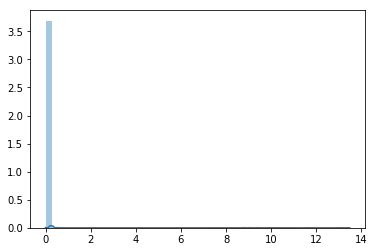

In [0]:
sns.distplot(preds2)

# A.S.

In [0]:
train_pay_week = add_week(train_payment)
test1_pay_week = add_week(test1_payment)
test2_pay_week = add_week(test2_payment)

train_pay_week.head()

,day,acc_id,amount_spent,week
0,18,27835,0.826123,3
1,23,27835,0.011735,4
2,27,27835,0.035204,4
3,17,12351,0.528062,3
4,11,125437,0.633674,2


In [0]:
train_payment_by_week = train_payment.groupby(['acc_id', 'week']).sum()['amount_spent'].reset_index().rename(columns = {'amount_spent':'payment'})
test1_payment_by_week = test1_payment.groupby(['acc_id', 'week']).sum()['amount_spent'].reset_index().rename(columns = {'amount_spent':'payment'})
test2_payment_by_week = test2_payment.groupby(['acc_id', 'week']).sum()['amount_spent'].reset_index().rename(columns = {'amount_spent':'payment'})

train_payment_by_week.head()

,acc_id,week,payment
0,8,1,1.056123
1,8,4,0.348521
2,20,2,0.070408
3,20,3,0.826123
4,21,3,2.346940


In [0]:
def add_label2(activity_by_week):
  # merge
  activity_stack = pd.merge(activity_by_week, train_label, on='acc_id', how='left')
  activity_stack['total_spent'] = activity_stack['survival_time'] * activity_stack['amount_spent']
  # survival time plus
  for i in range(1, 5):
    activity_stack.loc[activity_stack['week'] == i, 'survival_time'] = np.minimum(64, activity_stack.loc[activity_stack['week'] == i] + (7*(4-i)))
  #activity_stack
  
  return activity_stack

In [0]:
train_pay_label = add_label2(train_payment_by_week)
train_pay_label.head()

,acc_id,week,payment,survival_time,amount_spent,total_spent
0,8,1,1.056123,64.0,0.020310,1.299843
1,8,4,0.348521,64.0,0.020310,1.299843
2,20,2,0.070408,64.0,0.052137,3.336752
3,20,3,0.826123,64.0,0.052137,3.336752
4,21,3,2.346940,64.0,0.184267,11.793078


In [0]:
def change_amount_spent(pay_label):
  pay_lags = pd.concat([pay_label, 
                        pay_label.groupby('acc_id').shift(-1).reset_index().rename(columns={'payment':'lead1'})['lead1'], 
                        pay_label.groupby('acc_id').shift(-2).reset_index().rename(columns={'payment':'lead2'})['lead2'],
                        pay_label.groupby('acc_id').shift(-3).reset_index().rename(columns={'payment':'lead3'})['lead3']], axis=1)
  pay_lags['lead_sum'] = pay_lags['lead1'].fillna(0) + pay_lags['lead2'].fillna(0)
  
  for i in range(1, 5):
    pay_lags.loc[(pay_lags['week'] == i) & (pay_lags['survival_time'] == 64), 'total_spent'] = (pay_lags.loc[(pay_lags['week'] == i) & (pay_lags['survival_time'] == 64), 'total_spent']/64) * (71 - (7*i)) + pay_lags.loc[(pay_lags['week'] == i) & (pay_lags['survival_time'] == 64), 'lead_sum']
  pay_lags.loc[pay_lags['survival_time'] != 64, 'total_spent'] = pay_lags.loc[pay_lags['survival_time'] != 64, 'total_spent'] + pay_lags.loc[pay_lags['survival_time'] != 64, 'lead_sum']
  pay_lags['amount_spent'] = pay_lags['total_spent'] / pay_lags['survival_time']
  pay_lags = pay_lags[['acc_id', 'week', 'survival_time', 'amount_spent', 'total_spent']]

  return pay_lags

In [0]:
change_amount_spent(train_pay_label).head()

,acc_id,week,survival_time,amount_spent,total_spent
0,8,1,64.0,0.025756,1.648363
1,8,4,64.0,0.013646,0.873332
2,20,2,64.0,0.059342,3.797918
3,20,3,64.0,0.040732,2.606838
4,21,3,64.0,0.149404,9.561863
